# Sparkify - Subset Analytics

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, countDistinct, count, when, sum,col
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.feature import OneHotEncoder, StringIndexer, MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# create a Spark session
spark = (SparkSession.builder 
                    .master("local") 
                    .appName("Creating Features") 
                    .getOrCreate())

# Load and Clean Dataset
Clean the dataset, checking for invalid or missing data. 

In [3]:
events = spark.read.json('mini_sparkify_event_data.json')
events.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

# Exploratory Data Analysis
Performing EDA by loading a small subset of the data and doing basic manipulations within Spark will help us get an idea of the data we are looking at

Using pringSchema function of Spark dataframe to show the columns and data types of this dataset

In [4]:
events.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Using describe() to check the statistics of each column

In [5]:
events.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


Investigate *auth* column - We would like to understand all the unique values in the *auth* column

In [6]:
events.groupBy("auth").agg(countDistinct("userId")).toPandas()

,auth,count(DISTINCT userId)
0,Logged Out,1
1,Cancelled,52
2,Guest,1
3,Logged In,225


*auth* likely represents the status of the user. Most users are normal users (log in). 52 users cancelled their subscriptions. We will look at the *page* column to investigate their behaviors. 

In [7]:
events.groupBy("page").agg(count("userId")).toPandas()

,page,count(userId)
0,Cancel,52
1,Submit Downgrade,63
2,Thumbs Down,2546
3,Home,14457
4,Downgrade,2055
5,Roll Advert,3933
6,Logout,3226
7,Save Settings,310
8,Cancellation Confirmation,52
9,About,924


The same user cancellations amount showed up in *auth* column. Downgrade events also showed up in the page column. 

In [8]:
events.agg(countDistinct("artist"), 
           countDistinct('song'),
           countDistinct('userAgent')).toPandas()

,count(DISTINCT artist),count(DISTINCT song),count(DISTINCT userAgent)
0,17655,58480,56


user agent does not have a lot of different values, which could be utilized as a feature

### Define Churn

We will define Churn as `Cancellation Confirmation` events. We could also add `Downgrade` events as Churn, but we could use `Downgrade` events as an additional feature to predict `Cancellation Confirmation` events (Churn). 

Create a column named `Churn` as the label of whether the user has churned

In [9]:
# find the user_id of the churned users
churned_users = (events.filter(events.page == 'Cancellation Confirmation')
                       .select('userId')
                       .distinct()
                       .rdd.flatMap(lambda x: x)
                       .collect())

# # create a new column indicating the user has churned
events = events.withColumn('Churn', 
                            when(events.userId.isin(churned_users), 1).otherwise(0))

### Explore Data


Perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. 

**1.** Investigate the difference between the average number of songs played by churned/non-churned users

In [10]:
# filter events log to contain only next song
events_songs = events.filter(events.page == 'NextSong')

# users count
user_count = events_songs.groupby(events_songs.Churn).agg(countDistinct('userId'))

# Total songs played
total_songs = events_songs.groupby(events_songs.Churn).agg(sum('length'))

# find average length of the songs played
avg_song_length = (total_songs.join(user_count, total_songs.Churn == user_count.Churn)
                                   .drop(user_count.Churn))
avg_song_length = avg_song_length.withColumn('AvgLength', 
                                             avg_song_length['sum(length)']/ avg_song_length['count(DISTINCT userId)'])

Plot the difference in average length of songs

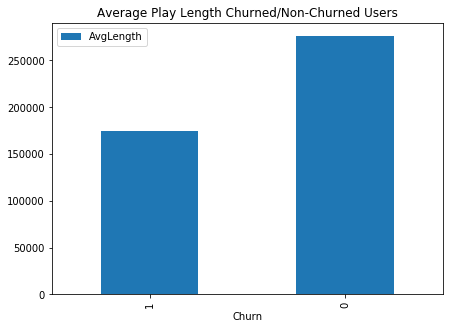

In [11]:
(avg_song_length.select('Churn', 'AvgLength')
                .toPandas()
                .set_index('Churn')
                .plot(kind = 'bar', figsize = (7, 5), title = 'Average Play Length Churned/Non-Churned Users'))

The non-churned users on average, used the service way more often than the churned users

**2.** Check other direct activities differences between the churned/non-churned users

Pivot the data on user level

In [12]:
events_pivot = events.groupby(["userId"]).pivot("page").count().fillna(0)

Convert the *events_pivot* dataframe to pandas, build box plots for all these different activities

In [13]:
events_pivot = events_pivot.toPandas()
events_pivot.rename(columns={'Cancellation Confirmation': 'Churn'}, inplace = True)

Plot boxplots for different activities

In [14]:
plot_columns = events_pivot.drop('Churn', axis = 1).columns

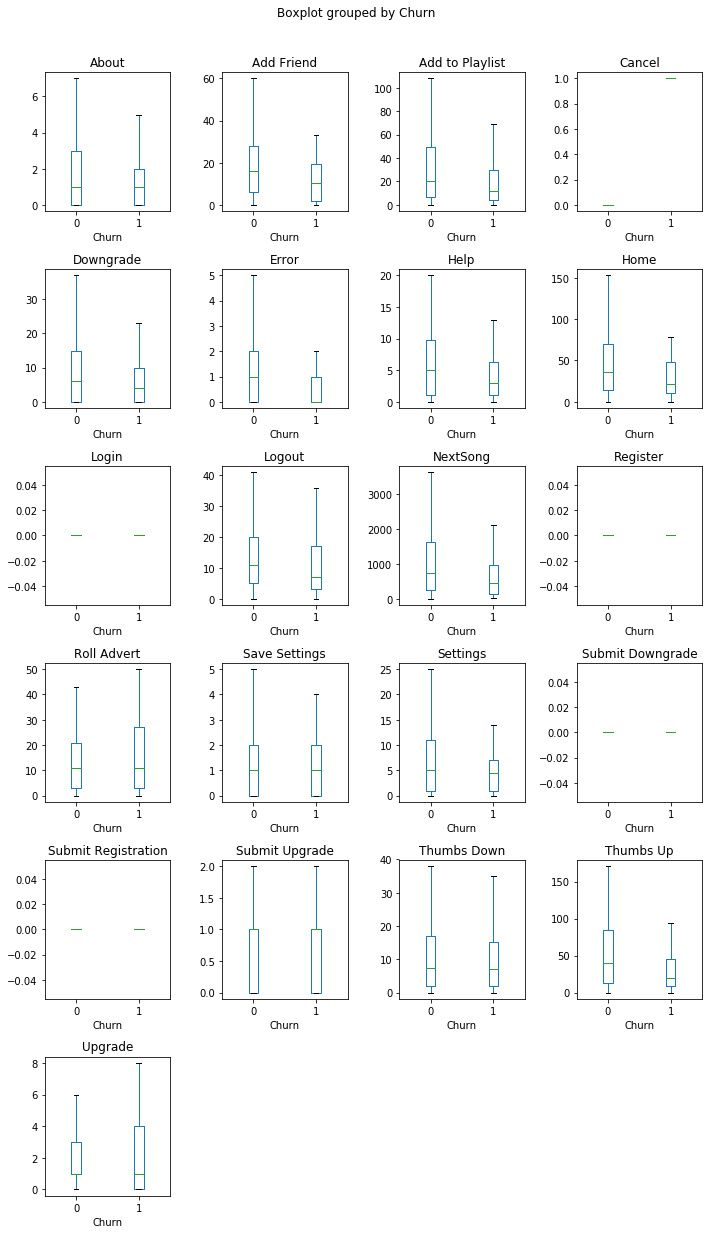

In [15]:
fig = plt.figure(figsize=(10, 18))

for i in range(1,len(plot_columns)):
    axis = fig.add_subplot(6,4,i)
    events_pivot.boxplot(plot_columns[i], ax = axis, 
                         grid = False,  by='Churn', showfliers=False)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

From the above analysis, it is evident that non churned users will have significant longer playing time than churned users. The following factors are also quite important contributing factors to the users churning. 

* Add Friends - Churned users are less likely to add friends
* Add to Playlist - Churned users are less likely to add to playlists
* Upgrade - Churned users have a wide range of upgrade activities
* NextSong - Churned users are less likely to play next song
* ThumbsUp - Churned users are less likely to press thumbs up
* Roll Advert - Churned users have a wider spread on roll advert
* Settings - Churned users less likely to visit settings page
* Log out - Churned users less likely to log out (due to less logins)
* Help - Non-churned users more likely to ask for help
* Home - Churned users less likely to visit home page

# Feature Engineering

Build 7 features that are needed to construct the model 

### Dimensionality Reductions - Removing Less Useful Features

Remove several less useful columns to speed up the opreations
* First Name
* Last Name
* auth
* status
* gender
* ItemInSession
* location
* method
* song
* artist


In [16]:
events = events.drop('firstName', 'lastName', 'auth', 'gender', 'song','artist',
                      'status', 'method', 'location', 'registration', 'itemInSession')

**1**. pivot the page column to obtain different activities for the user, then remove the less significant features

In [17]:
events_pivot = events.groupby(["userId"]).pivot("page").count().fillna(0)
events_pivot = events_pivot.drop('About', 'Cancel', 'Login',  'Submit Registration',  'Register', 'Save Settings')

**2.** Add average song played length

In [18]:
# filter events log to contain only next song
events_songs = events.filter(events.page == 'NextSong')

# Total songs length played
total_length = events_songs.groupby(events_songs.userId).agg(sum('length'))

# join events pivot
events_pivot = (events_pivot.join(total_length, on = 'userId', how = 'left')
                            .withColumnRenamed("Cancellation Confirmation", "Churn")
                            .withColumnRenamed("sum(length)", "total_length"))

**3.** Add days active

In [19]:
convert = 1000*60*60*24 # conversion factor to days

# Find minimum/maximum time stamp of each user
min_timestmp = events.select(["userId", "ts"]).groupby("userId").min("ts")
max_timestmp = events.select(["userId", "ts"]).groupby("userId").max("ts")

# Find days active of each user
daysActive = min_timestmp.join(max_timestmp, on="userId")
daysActive = (daysActive.withColumn("days_active", 
                                   (col("max(ts)")-col("min(ts)")) / convert))
daysActive = daysActive.select(["userId", "days_active"])

# join events pivot
events_pivot = events_pivot.join(daysActive, on = 'userId', how = 'left')

**4.** Add number of sessions

In [20]:
numSessions = (events.select(["userId", "sessionId"])
                      .distinct()
                      .groupby("userId")
                       .count()
                      .withColumnRenamed("count", "num_sessions"))

# join events pivot
events_pivot = events_pivot.join(numSessions, on = 'userId', how = 'left')

**5.** Add days as paid user

In [21]:
# Find minimum/maximum time stamp of each user as paid user
paid_min_ts = events.filter(events.level == 'paid').groupby("userId").min("ts")
paid_max_ts = events.filter(events.level == 'paid').groupby("userId").max("ts")

# Find days as paid user of each user

daysPaid = paid_min_ts.join(paid_max_ts, on="userId")
daysPaid = (daysPaid.withColumn("days_paid", 
                                (col("max(ts)")-col("min(ts)")) / convert))
daysPaid = daysPaid.select(["userId", "days_paid"])

# join events pivot
events_pivot = events_pivot.join(daysPaid, on = 'userId', how='left')

**6.** Add days as a free user

In [22]:
# Find minimum/maximum time stamp of each user as paid user
free_min_ts = events.filter(events.level == 'free').groupby("userId").min("ts")
free_max_ts = events.filter(events.level == 'free').groupby("userId").max("ts")

# Find days as paid user of each user
daysFree = free_min_ts.join(free_max_ts, on="userId")
daysFree = (daysFree.withColumn("days_free", 
                                (col("max(ts)")-col("min(ts)")) / convert))
daysFree = daysFree.select(["userId", "days_free"])

# join events pivot
events_pivot = events_pivot.join(daysFree, on = 'userId', how='left')

**7.** Add user access agent

In [23]:
# find user access agents, and perform one-hot encoding on the user 
userAgents = events.select(['userId', 'userAgent']).distinct()
userAgents = userAgents.fillna('Unknown')

# build string indexer
stringIndexer = StringIndexer(inputCol="userAgent", outputCol="userAgentIndex")
model = stringIndexer.fit(userAgents)
userAgents = model.transform(userAgents)

# one hot encode userAgent column
encoder = OneHotEncoder(inputCol="userAgentIndex", outputCol="userAgentVec")
userAgents = encoder.transform(userAgents).select(['userId', 'userAgentVec'])

# join events pivot
events_pivot = events_pivot.join(userAgents, on = 'userId', how ='left')

**8.** Fill all empty values as 0

In [24]:
events_pivot = events_pivot.fillna(0)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [25]:
# Split data into train and test set
events_pivot = events_pivot.withColumnRenamed('Churn', 'label')
training, test = events_pivot.randomSplit([0.8, 0.2])

Build machine learning pipeline

In [26]:
# Create vector from feature data
feature_names = events_pivot.drop('label', 'userId').schema.names
vec_asembler = VectorAssembler(inputCols = feature_names, outputCol = "Features")

# Scale each column
scalar = MinMaxScaler(inputCol="Features", outputCol="ScaledFeatures")

# build classifiers
rf = RandomForestClassifier(featuresCol="ScaledFeatures", labelCol="label",
                                numTrees = 50,  featureSubsetStrategy='sqrt')

lr = LogisticRegression(featuresCol="ScaledFeatures", labelCol="label", 
                        maxIter=10, regParam=0.01)

gbt = GBTClassifier(featuresCol="ScaledFeatures", labelCol="label")

# Consturct 3 pipelines
pipeline_rf = Pipeline(stages=[vec_asembler, scalar, rf])
pipeline_lr = Pipeline(stages=[vec_asembler, scalar, lr])
pipeline_gbt = Pipeline(stages=[vec_asembler, scalar, gbt])

Fit the model

In [27]:
rf_model = pipeline_rf.fit(training)
lr_model = pipeline_lr.fit(training)
gbt_model = pipeline_gbt.fit(training)

Test performances for each model

In [28]:
def modelEvaluations(model, metric, data):
    """ Evaluate a machine learning model's performance 
        Input: 
            model - pipeline object
            metric - the metric of the evaluations
            data - data being evaluated
        Output:
            [score, confusion matrix]
    """
    # generate predictions
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    predictions = model.transform(data)
    
    # calcualte score
    score = evaluator.evaluate(predictions)
    confusion_matrix = (predictions.groupby("label")
                                   .pivot("prediction")
                                   .count()
                                   .toPandas())
    return [score, confusion_matrix]

In [29]:
f1_rf, conf_mtx_rf = modelEvaluations(rf_model, 'f1', test)
f1_lr, conf_mtx_lr = modelEvaluations(lr_model, 'f1', test)
f1_gbt, conf_mtx_gbt = modelEvaluations(gbt_model, 'f1', test)

In [30]:
print('The F1 score for the random forest model:', f1_rf)
conf_mtx_rf

The F1 score for the random forest model: 0.7777777777777779


,label,0.0,1.0
0,0,32,3.0
1,1,5,NaN


In [31]:
print('The F1 score for the logistic regression model:', f1_lr)
conf_mtx_lr

The F1 score for the logistic regression model: 0.7640845070422536


,label,0.0,1.0
0,0,31,4.0
1,1,5,NaN


In [32]:
print('The F1 score for the gradient boosting model:', f1_gbt)
conf_mtx_gbt

The F1 score for the gradient boosting model: 0.803846153846154


,label,0.0,1.0
0,0,28,7
1,1,2,3


Gradient boosting model yields the best F1 score. Due to the size limitation of the dataset, the parameters obtained from these 3 models would not be applicable to the full 12GB dataset. Therefore, hyperparameter tuning step was neglected.

**Feature Importance**

Find out the relative feature importances of the model

In [45]:
feature_importances = np.array(gbt_model.stages[-1].featureImportances)
userAgentVec = feature_importances[len(feature_names) :].sum()
feature_importances = feature_importances[:len(feature_names)] + [userAgentVec]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

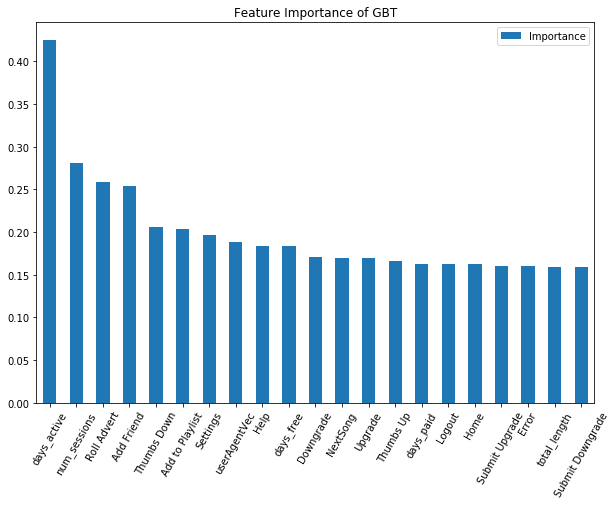

In [60]:
feature_importance = pd.DataFrame(feature_importances, 
                                     index = feature_names,
                                     columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
feature_importance.plot(kind = 'bar', figsize = (10, 7), title = 'Feature Importance of GBT')
plt.xticks(rotation = 60)

The number of days a user is active on the service is the most important contributing factor of user churning

# Final Steps

Perform full analytics on AWS 